In [1]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F

spark = SparkSession.builder.getOrCreate()

In [2]:
spark

 ##  *1. Wie viele Kunden-Datensätze gibt es in der Datei iw_customer.txt? Zeige die ersten 5 Kunden.* 

In [3]:
df=spark.read.csv("gs://dataproc-staging-europe-west1-908939104126-4c7em3li/data/webshop/iw_customer.txt", sep="\t", header=True) 
df.count()

247065

In [4]:
df.show(5)

+-----+----------+----------+---------+-------+--------+-----------+-------------+-------------+----------+--------------------+--------+------+-----------+
|owner|customerNo|salutation|firstname|surname|postcode|       city|       street|        eMail|newsletter|           birthdate|  riskID|credit|creditLimit|
+-----+----------+----------+---------+-------+--------+-----------+-------------+-------------+----------+--------------------+--------+------+-----------+
|   IW| KNR000001|      Frau|    Abcde|Hijklmn|   65232|Taunusstein|Opqrst-Street|mail@mail.com|         1|1968-01-07 00:00:...|69918055|   400|          1|
|   IW| KNR000002|      Frau|    Abcde|Hijklmn|   26904|     Börger|Opqrst-Street|mail@mail.com|         0|1978-10-10 00:00:...|92843675|  1000|          1|
|   IW| KNR000003|      Frau|    Abcde|Hijklmn|   78333|   Stockach|Opqrst-Street|mail@mail.com|         1|1967-04-29 00:00:...|11272894|     0|          2|
|   IW| KNR000011|      Frau|    Abcde|Hijklmn|   79618|Rh

## 2. Entfernen Sie folgende Attribute aus dem DataFrame: 'owner', 'firstname', 'lastname','street', 'eMail'.

In [5]:
df = df.drop('owner', 'firstname', 'surname','street', 'eMail')
df.show()

+----------+----------+--------+--------------------+----------+--------------------+--------+------+-----------+
|customerNo|salutation|postcode|                city|newsletter|           birthdate|  riskID|credit|creditLimit|
+----------+----------+--------+--------------------+----------+--------------------+--------+------+-----------+
| KNR000001|      Frau|   65232|         Taunusstein|         1|1968-01-07 00:00:...|69918055|   400|          1|
| KNR000002|      Frau|   26904|              Börger|         0|1978-10-10 00:00:...|92843675|  1000|          1|
| KNR000003|      Frau|   78333|            Stockach|         1|1967-04-29 00:00:...|11272894|     0|          2|
| KNR000011|      Frau|   79618|         Rheinfelden|         1|1974-10-21 00:00:...|86364865|   400|          1|
| KNR000020|      Frau|   64625|            Bensheim|         1|1969-03-23 00:00:...|79987284|   500|          1|
| KNR000022|      Herr|   45138|               Essen|         1|1957-06-04 00:00:...|876

## *3. Entfernen Sie alle Kunden, die vor 1900 geboren worden sind, aus dem DataFrame.*

In [6]:
df2 = df.where(df.birthdate[0:4] >= '1900')
df2.count()

247021

In [7]:
print("Es sind", df.count() - df2.count(), "Kunden vor 1900 geboren.") 

Es sind 44 Kunden vor 1900 geboren.


##  4. Nennen Sie das Attribut 'birthdate' in 'birthyear' um und speichern Sie entsprechend nur noch das Geburtsjahr im DataFrame.

In [8]:
df = df.withColumnRenamed("birthdate", "birthyear")
df = df.withColumn("birthyear", df["birthyear"].substr(1, 4))
df.show()

+----------+----------+--------+--------------------+----------+---------+--------+------+-----------+
|customerNo|salutation|postcode|                city|newsletter|birthyear|  riskID|credit|creditLimit|
+----------+----------+--------+--------------------+----------+---------+--------+------+-----------+
| KNR000001|      Frau|   65232|         Taunusstein|         1|     1968|69918055|   400|          1|
| KNR000002|      Frau|   26904|              Börger|         0|     1978|92843675|  1000|          1|
| KNR000003|      Frau|   78333|            Stockach|         1|     1967|11272894|     0|          2|
| KNR000011|      Frau|   79618|         Rheinfelden|         1|     1974|86364865|   400|          1|
| KNR000020|      Frau|   64625|            Bensheim|         1|     1969|79987284|   500|          1|
| KNR000022|      Herr|   45138|               Essen|         1|     1957|87651195|   400|          1|
| KNR000023|      Frau|   31812|         Bad Pyrmont|         1|     1967

## *5. Ersetzen Sie im Attribut 'salutation' alle Werte 'Frau' durch 'weiblich' sowie 'Herr' durch'männlich' und nennen Sie das Attribut in 'gender' um.*

In [9]:
df = df.withColumnRenamed('salutation', 'gender')

In [10]:
from pyspark.sql.functions import regexp_replace
df = df.withColumn("gender", regexp_replace("gender", "Frau", "weiblich"))
df = df.withColumn("gender", regexp_replace("gender", "Herr", "männlich"))  
df.select("gender").show()

+--------+
|  gender|
+--------+
|weiblich|
|weiblich|
|weiblich|
|weiblich|
|weiblich|
|männlich|
|weiblich|
|weiblich|
|weiblich|
|weiblich|
|weiblich|
|weiblich|
|weiblich|
|weiblich|
|weiblich|
|weiblich|
|weiblich|
|weiblich|
|weiblich|
|weiblich|
+--------+
only showing top 20 rows



## 6. Ergänzen Sie das Dataframe durch ein Attribut 'state', in dem das Bundesland zur PLZ gespeichert sein soll. Die Bundesländer entnehmen Sie bitte aus der Datei plz_mapping.txt.

In [11]:
df_map = spark.read.csv("gs://dataproc-staging-europe-west1-908939104126-4c7em3li/data/webshop/plz_mapping.txt", sep="\t", header=True)
df_map = df_map.withColumnRenamed('Bundesland','state')
df_map.show()

+-----+-------+-------+-----+
|  PLZ|  state|  Kreis|  Typ|
+-----+-------+-------+-----+
|01067|Sachsen|Dresden|Stadt|
|01069|Sachsen|Dresden|Stadt|
|01097|Sachsen|Dresden|Stadt|
|01099|Sachsen|Dresden|Stadt|
|01108|Sachsen|Dresden|Stadt|
|01109|Sachsen|Dresden|Stadt|
|01127|Sachsen|Dresden|Stadt|
|01129|Sachsen|Dresden|Stadt|
|01139|Sachsen|Dresden|Stadt|
|01156|Sachsen|Dresden|Stadt|
|01157|Sachsen|Dresden|Stadt|
|01159|Sachsen|Dresden|Stadt|
|01169|Sachsen|Dresden|Stadt|
|01187|Sachsen|Dresden|Stadt|
|01189|Sachsen|Dresden|Stadt|
|01217|Sachsen|Dresden|Stadt|
|01219|Sachsen|Dresden|Stadt|
|01237|Sachsen|Dresden|Stadt|
|01239|Sachsen|Dresden|Stadt|
|01257|Sachsen|Dresden|Stadt|
+-----+-------+-------+-----+
only showing top 20 rows



In [12]:
df_map = df_map.drop('Kreis','Typ')
df_map = df_map.withColumnRenamed('PLZ','postcode')
df = df.join(df_map,'postcode','left')
df.show()

+--------+----------+--------+--------------------+----------+---------+--------+------+-----------+-------------------+
|postcode|customerNo|  gender|                city|newsletter|birthyear|  riskID|credit|creditLimit|              state|
+--------+----------+--------+--------------------+----------+---------+--------+------+-----------+-------------------+
|   65232| KNR000001|weiblich|         Taunusstein|         1|     1968|69918055|   400|          1|             Hessen|
|   26904| KNR000002|weiblich|              Börger|         0|     1978|92843675|  1000|          1|      Niedersachsen|
|   78333| KNR000003|weiblich|            Stockach|         1|     1967|11272894|     0|          2|  Baden-Württemberg|
|   79618| KNR000011|weiblich|         Rheinfelden|         1|     1974|86364865|   400|          1|  Baden-Württemberg|
|   64625| KNR000020|weiblich|            Bensheim|         1|     1969|79987284|   500|          1|             Hessen|
|   45138| KNR000022|männlich|  

## 7. Persistieren Sie das bisher konstruierte DataFrame als Tabelle 'customers'. Die Tabelle wird per Default im Hive-Metastore unter /user/hive/warehouse/customers abgelegt.

In [13]:
#df.write.csv("/user/hive/warehouse/customers/customers.csv")

### 8. Leider wird in dem Webshop i.d.R. als Gast ohne Kundenkonto bestellt. Daher existieren viele Kunden-Dupletten. Alle Datensätze mit gleichem Wert im Attribut 'riskId' sollen als ein eindeutiger Kunde in einem neuen DataFrame 'uniqueCustomers' zusammengeführt werden. Das DataFrame 'uniqueCustomers' soll als Tabelle persistiert und für die Beantwortung der noch folgenden Punkte verwendet werden.

In [28]:
uniqueCustomers = df.dropDuplicates(['riskID'])
print("Es gibt ",df.count() - uniqueCustomers.count(),"Duplikate, und somit ", uniqueCustomers.count(), "viele Kunden")

Es gibt  139388 Duplikate, und somit  107677 viele Kunden


In [15]:
#uniqueCustomers.write.csv("/user/hive/warehouse/customers/uniqueCustomers.csv")

## 9. Erstellen Sie ein Kreisdiagramm, dass die Verteilung der Kunden je Geschlecht visualisiert.

In [16]:
# importing pyplot from matplotlib
# matplotlib is a 2D Python plotting library

from matplotlib import pyplot as pp 
#df_grouped = df.groupBy(["gender"]).count().show()
#df_grouped.show()
women = uniqueCustomers.filter("gender == 'weiblich'").count()
men = uniqueCustomers.filter("gender == 'männlich'").count()


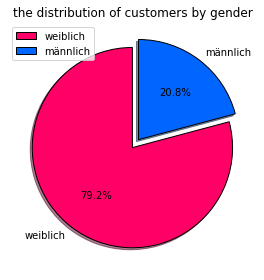

In [17]:

slices  = [women, men]
labels  = ["weiblich", "männlich"]
colors  = ["#ff0066", "#0066ff"]
explode = [0, 0.1]


pp.pie(slices, labels=labels, colors=colors,explode=explode, shadow=True, startangle=90,
       autopct="%1.1f%%", wedgeprops={"edgecolor":"black"})

pp.title("the distribution of customers by gender")
pp.legend(loc="upper left")
pp.tight_layout()
pp.show()

## 10. Erstellen Sie ein Balkendiagramm, dass die Verteilung der Kunden je Bundesland und je Geschlecht visualisiert. Die Verteilung soll absteigend sortiert nach Häufigkeit der Kunden je Bundesland sein.

                     state  Anzahl Frauen  Anzahl Männer
12     Nordrhein-Westfalen          18479           5178
10                  Bayern          15998           4057
13       Baden-Württemberg          13199           3166
3                   Hessen           8106           1854
1            Niedersachsen           7743           1986
2          Rheinland-Pfalz           4216           1024
11                  Berlin           3075           1370
0       Schleswig-Holstein           3181            755
14                 Hamburg           2798            749
5                  Sachsen           2275            634
15               Thüringen           1310            380
4           Sachsen-Anhalt           1223            372
7              Brandenburg           1144            290
8   Mecklenburg-Vorpommern           1075            270
9                   Bremen            605            187
6                 Saarland            596            151


<AxesSubplot:title={'center':'Kunden pro Bundesland'}, xlabel='state'>

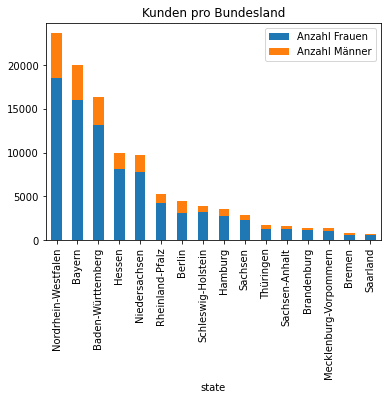

In [18]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql.functions import col

uniqueCustomers = uniqueCustomers.dropna(how='any')

grouped = uniqueCustomers.groupby('state','gender').count()

women = grouped.select('count','state').filter("gender == 'weiblich'")
men = grouped.select('count','state').filter("gender == 'männlich'")

women = women.withColumnRenamed('count','Anzahl Frauen')
men = men.withColumnRenamed('count','Anzahl Männer')


df_all = women.join(men, 'state', 'right')
df_all = df_all.withColumn("Summe", col("Anzahl Frauen")+col("Anzahl Männer"))

df_pandas = df_all.toPandas()
df_pandas = df_pandas.sort_values(by=['Summe'], ascending=False)
df_pandas = df_pandas.drop(columns=['Summe'])
print(df_pandas)


df_pandas.plot.bar(x='state', stacked=True, title='Kunden pro Bundesland')

## 11. Lesen Sie die Umsätze (iw_sales.txt) und Retouren (return_line.txt) für weitere dispositive Fragestellungen ein.

In [19]:
df_s =spark.read.csv("gs://dataproc-staging-europe-west1-908939104126-4c7em3li/data/webshop/iw_sales.txt", sep="\t", header=True) 
df_r =spark.read.csv("gs://dataproc-staging-europe-west1-908939104126-4c7em3li/data/webshop/iw_return_line.txt", sep="\t", header=True) 

In [20]:
df_s.show(5)
df_r.show(5)

+-----+-------+---------+----------+----+-------------+--------+------+----------+-----------+----------+---------------+--------------------+--------------------+
|owner|line_No|  orderNo|customerNo|type|         IWAN|quantity|amount|vat_amount|line_amount|VATpercent|bill_customerNo|           orderDate|         postingDate|
+-----+-------+---------+----------+----+-------------+--------+------+----------+-----------+----------+---------------+--------------------+--------------------+
|   IW|      3|ORD003892| KNR765310|   2|2534460662171|       1| 33.53|     39.90|      39.90|        19|      KNR765310|2010-05-11 00:00:...|2010-05-17 00:00:...|
|   IW|      2|ORD003892| KNR765310|   2|2534160651495|       1| 33.53|     39.90|      39.90|        19|      KNR765310|2010-05-11 00:00:...|2010-05-17 00:00:...|
|   IW|      1|ORD003892| KNR765310|   2|2534550694026|       1| 33.53|     39.90|      39.90|        19|      KNR765310|2010-05-11 00:00:...|2010-05-17 00:00:...|
|   IW|      4|O

## 12. Gruppieren Sie die Umsätze des Jahres 2011 je Monat und stellen Sie diese in einem Balkendiagramm dar. Die Spalte orderDate ist für die Feststellung des Bestelldatumszu verwenden

+----------------+------------------+
|month(orderDate)|            Umsatz|
+----------------+------------------+
|               1|3049269.9599990244|
|              12| 2457831.139998979|
|               6|1874199.4999989704|
|               3|2152750.2699987646|
|               5| 2357247.499998723|
|               9|1626960.0399994834|
|               2| 2423543.729998908|
|               4|1754057.4299991522|
|               8|2027927.6199983486|
|               7|1898961.6099985344|
|              10|2388400.1299991133|
|              11| 2412094.329999134|
+----------------+------------------+



<AxesSubplot:title={'center':'Umsatz im Jahr 2011'}, xlabel='month(orderDate)'>

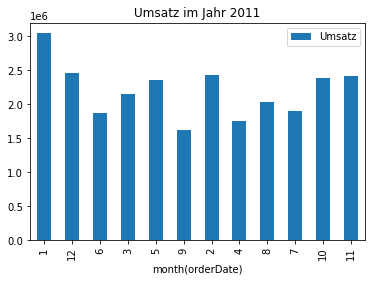

In [29]:
import pyspark.sql.types
import pyspark.sql.functions as sf

df_s = df_s.withColumn("line_amount", df_s.line_amount.cast('double'))

df_sales_2011 = df_s.filter(sf.year('orderdate') == 2011)

df_spm_2011 = df_sales_2011.groupby(sf.month('orderDate')).agg(sf.sum('line_amount').alias('Umsatz'))
df_spm_2011.show()

df_spm_pandas = df_spm_2011.toPandas()

df_spm_pandas.plot.bar(x='month(orderDate)', title='Umsatz im Jahr 2011', )



## 13. Wie viele Bestellungen (Note: Es kann durchaus mehrere Bestellpositionen zu einer Bestellung geben, jede Bestellung ist eindeutig durch die Spalte orderNo) je Kunden gibt es durchschnittlich?

In [22]:
from pyspark.sql.types import *
from pyspark.sql.functions import avg

df_s.createOrReplaceTempView("sales") # Register the DataFrame as a SQL temporary view

sqlDF = spark.sql("SELECT round(avg(count),2) as Durchschnittliche_Bestellungen_pro_Kunde FROM (SELECT DISTINCT count(orderNO) as count FROM sales group by customerNo)")
sqlDF.show()

+----------------------------------------+
|Durchschnittliche_Bestellungen_pro_Kunde|
+----------------------------------------+
|                                   12.13|
+----------------------------------------+



## 14  Was ist die durchschnittliche Anzahl an Bestellpositionen und der durchschnittliche Gesamtbetrag einer Bestellung über alle Kunden?

In [23]:
df_sales_per_customer = df_s.groupby('customerNo').agg(sf.count('orderNo').alias('amount_of_orders'), sf.sum('line_amount').alias("sum_of_orders"))
df_sales_per_customer.show()

mean_sales_and_spend = df_sales_per_customer.agg(sf.mean('amount_of_orders'), sf.mean('sum_of_orders'))
mean_sales_and_spend.show()

+----------+----------------+------------------+
|customerNo|amount_of_orders|     sum_of_orders|
+----------+----------------+------------------+
| KNR918710|               7|342.54999999999995|
| KNR896410|               4|            203.65|
| KNR208610|               5|            143.75|
| KNR278610|               2|            132.95|
| KNR876310|               2|             63.85|
| KNR688410|               2|             43.85|
| KNR945110|               6|373.45000000000005|
| KNR809310|               3|            138.75|
| KNR362710|               3|222.85000000000002|
| KNR903710|               5|            168.55|
| KNR183710|               3|            103.75|
| KNR712810|               2|             43.85|
| KNR806110|               2|            202.95|
| KNR763710|               4|            222.75|
| KNR105510|               4|            450.95|
| KNR319210|               5|198.54999999999998|
| KNR874810|               5|             229.6|
| KNR045810|        

+---------------------+------------------+
|avg(amount_of_orders)|avg(sum_of_orders)|
+---------------------+------------------+
|   3.3129945560884786| 188.6010749397632|
+---------------------+------------------+



## 15. Ermitteln Sie die Anzahl der Bestellpositionen und die Anzahl der retournierten Positionen je Bundesland. Die Kundenadresse ist hier als Ort der Bestellung anzunehmen. Bestimmen Sie anschließend die Retourenquote (= Anzahl an Retourenpositionen / Anzahl an Bestellpositionen)


In [24]:
sales_withCustomers = uniqueCustomers.join(df_s,'customerNo', 'left')
position_per_state = sales_withCustomers.groupby('state').agg(sf.count('orderNo').alias('sales'))
position_per_state.show()


+--------------------+-----+
|               state|sales|
+--------------------+-----+
|      Sachsen-Anhalt| 5518|
|       Niedersachsen|30009|
|         Brandenburg| 4686|
|              Berlin|14260|
|              Bayern|64903|
|             Sachsen| 9939|
|             Hamburg|10643|
|              Bremen| 2351|
| Nordrhein-Westfalen|73002|
|           Thüringen| 5907|
|              Hessen|31694|
|   Baden-Württemberg|52650|
|Mecklenburg-Vorpo...| 4474|
|            Saarland| 2320|
|  Schleswig-Holstein|12050|
|     Rheinland-Pfalz|16906|
+--------------------+-----+



In [25]:
df_return = spark.read.csv("gs://dataproc-staging-europe-west1-908939104126-4c7em3li/data/webshop/iw_return_line.txt", sep="\t", header=True)

df_return_customer = uniqueCustomers.join(df_return,'customerNo', 'left')
df_return_customer.count()
df_return_per_state = df_return_customer.groupby('state').agg(sf.count('returnNo').alias('returns'))
df_return_per_state.show()

+--------------------+-------+
|               state|returns|
+--------------------+-------+
|      Sachsen-Anhalt|   2175|
|       Niedersachsen|  12056|
|         Brandenburg|   1779|
|              Berlin|   6467|
|              Bayern|  25676|
|             Sachsen|   4129|
|             Hamburg|   3839|
|              Bremen|    842|
| Nordrhein-Westfalen|  27622|
|           Thüringen|   2533|
|              Hessen|  12179|
|   Baden-Württemberg|  21096|
|Mecklenburg-Vorpo...|   1734|
|            Saarland|    941|
|  Schleswig-Holstein|   4486|
|     Rheinland-Pfalz|   6724|
+--------------------+-------+



In [26]:
df_ratio = df_return_per_state.join(position_per_state, 'state', 'left')
df_ratio = df_ratio.withColumn('ratio', col('returns') / col('sales')) 
df_ratio.show()

+--------------------+-------+-----+-------------------+
|               state|returns|sales|              ratio|
+--------------------+-------+-----+-------------------+
|      Sachsen-Anhalt|   2170| 5619| 0.3861897134721481|
|       Niedersachsen|  12091|29990| 0.4031677225741914|
|         Brandenburg|   1776| 4674|0.37997432605905007|
|              Berlin|   6483|14198| 0.4566136075503592|
|              Bayern|  25779|64845| 0.3975479990747166|
|             Sachsen|   4125| 9968| 0.4138242375601926|
|             Hamburg|   3824|10641|0.35936472136077435|
|              Bremen|    848| 2356| 0.3599320882852292|
| Nordrhein-Westfalen|  27701|72977|0.37958534880852873|
|           Thüringen|   2546| 5950|0.42789915966386555|
|              Hessen|  12158|31563|0.38519785825175046|
|   Baden-Württemberg|  21004|52679| 0.3987167562026614|
|Mecklenburg-Vorpo...|   1740| 4509|0.38589487691284097|
|            Saarland|    939| 2345| 0.4004264392324094|
|  Schleswig-Holstein|   4458|1